# Info about notebook...

This notebook... (Fill out later)

### Dataset Notes
**Retinal Image Dataset**
- Dataset can be found [here.](https://www.kaggle.com/datasets/ipythonx/retinal-vessel-segmentation) ***File size = 648.3 MB***
- Contains two mask types: Eye mask, and Retina mask.
- Only working with data in CHASE_DB1, and HRF
- Every single image in `CHASE_DB1/Images` has two masks in `CHASE_DB1/Masks` 

**Lung Segmentation Dataset**
- The dataset can be found or [here](https://github.com/IlliaOvcharenko/lung-segmentation/tree/master) or directly through this [link.](https://drive.google.com/file/d/1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ/view?usp=sharing) ***File size = 4.19GB***

**Skin Lesion Segmentation Dataset**
- The dataset can be found or [here](https://challenge.isic-archive.com/data/#2017) or directly through this [link.](https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip) The masks here are in superpixel format ***File size = 5.8GB***. Binary masks can be found [here](https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip) ***File size = 9MB***

# Library downloads.

In [174]:
!pip install gdown

# Importing Important Libraries

In [206]:
# File System Handling
import os
import gdown
import tarfile
import zipfile

# Data Processing
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Image Visualization
from PIL import Image
import matplotlib.pyplot as plt

# Model Training, evaluation processes...
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models

# Handling Warnings
import warnings
warnings.filterwarnings("ignore")

# Organizing Train images path

## Image Paths or Url

In [297]:
# Declaring all paths, and URLs.

# **Retina Images**
EYE_IMAGES_1 = "/kaggle/input/retinal-vessel-segmentation/CHASE_DB1/Images"
EYE_IMAGES_2 = "/kaggle/input/retinal-vessel-segmentation/HRF/images"

EYE_MASKS_1 = "/kaggle/input/retinal-vessel-segmentation/CHASE_DB1/Masks"
EYE_MASKS_2 = "/kaggle/input/retinal-vessel-segmentation/HRF/manual1"

# **Lungs Images**
# Sharing URL modified to Download URL
# FROM THIS FORMAT BELOW
# https://drive.google.com/file/d/FILE_ID/view?usp=sharing
# TO THIS FORMAT BELOW
# https://drive.google.com/uc?export=download&id=FILE_ID
LUNG_IMAGES = "https://drive.google.com/uc?export=download&id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ"
LUNG_BASE_DIR = "/kaggle/working/lungs/"
LUNG_IMAGES_DIR = os.path.join(LUNG_BASE_DIR, "dataset", "images")
LUNG_MASKS_DIR = os.path.join(LUNG_BASE_DIR, "dataset", "masks")

# **Skin Lesion Images**
SKIN_LESION_BASE_DIR = "/kaggle/working/skin_lesion"
SKIN_LESION_IMAGES = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip"
SKIN_LESION_BINARY_MASKS = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip"

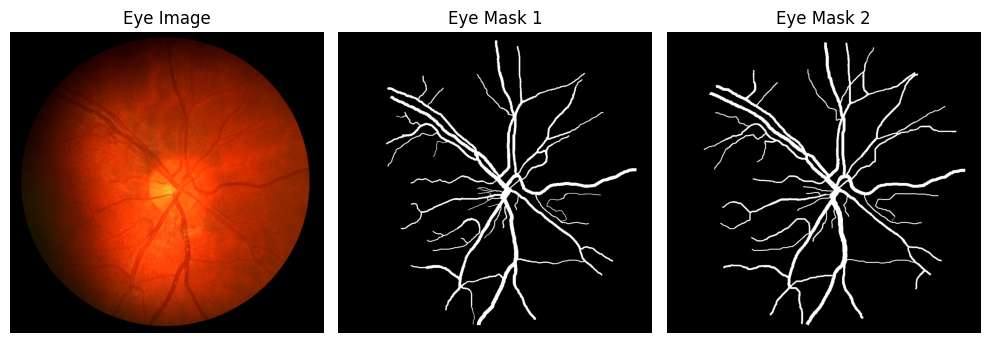

In [205]:
# Sample of an image an eye image and its two labels.
# Notice how they slightly differ?
# I will include both samples in training data as some form of
# augmentation as well.

# 0 > i < 14
i = "14" # Adjust to see different images. Numbers below 10 start with 0 e.g "02"

plt.subplots(1,3, figsize = (10,10))

plt.subplot(1,3,1)
plt.title("Eye Image")
im = Image.open(os.path.join(EYE_IMAGES_1, f"Image_{i}R.jpg"))
plt.imshow(im)
plt.axis(False);

plt.subplot(1,3,2)
plt.title("Eye Mask 1")
im = Image.open(os.path.join(EYE_MASKS_1, f"Image_{i}R_1stHO.png"))
plt.axis(False)
plt.imshow(im, cmap='gray')

plt.subplot(1,3,3)
plt.title("Eye Mask 2")
im = Image.open(os.path.join(EYE_MASKS_1, f"Image_{i}R_2ndHO.png"))
plt.axis(False)
plt.imshow(im, cmap='gray');
plt.tight_layout();

### Retina Images

In [228]:
# ============== Sorting Images and masks in CHASE_DB1 ============== #
image_paths = [] # list of images.
mask_paths = [] # list of corresponding image masks.

count = 0

for image in os.listdir(EYE_IMAGES_1): # Looping through every image
    image_masks = [] # List to store the two mask paths per image
    
    for mask in os.listdir(EYE_MASKS_1): # Looping through all masks
        if image[:9] in mask: # Checking if mask name has image name in it
            image_paths.append(os.path.join(EYE_IMAGES_1, image)) # Adding image path
            mask_paths.append(os.path.join(EYE_MASKS_1, mask)) # Adding corresponding mask path
            
image_paths = sorted(image_paths)
mask_paths = sorted(mask_paths)

# ============== Sorting Images and masks in HRF ============== #
retina_image_paths = sorted(image_paths + [os.path.join(EYE_IMAGES_2, path) for path in os.listdir(EYE_IMAGES_2)])
retina_mask_paths = sorted(mask_paths + [os.path.join(EYE_MASKS_2, path) for path in os.listdir(EYE_MASKS_2)])

print(f"Rentina:\nThere are {len(retina_image_paths)} training images, and {len(retina_mask_paths)} masks.")

Rentina:
There are 101 training images, and 101 masks.


### Lungs Images

In [180]:
# Creating base dir for lung images
os.makedirs(LUNG_BASE_DIR, exist_ok = True)

# Downloading dataset.
gdown.download(LUNG_IMAGES, LUNG_BASE_DIR, quiet = False)

# Extracting downloaded dataset
with tarfile.open("/kaggle/working/lungs/dataset.tar.gz", "r:gz") as zip_ref:
    zip_ref.extractall(LUNG_BASE_DIR)
    
# Deleting zipped file
os.remove(os.path.join(LUNG_BASE_DIR, "dataset.tar.gz"))

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ
From (redirected): https://drive.google.com/uc?export=download&id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ&confirm=t&uuid=72b53c99-ce7c-4b6f-ab9e-f10951b4684b
To: /kaggle/working/lungs/dataset.tar.gz
100%|██████████| 4.40G/4.40G [01:11<00:00, 61.7MB/s]


'/kaggle/working/lungs/dataset.tar.gz'

In [291]:
# Sorting Train Image Paths
lung_image_paths = sorted([os.path.join(LUNG_IMAGES_DIR, path) for path in os.listdir(LUNG_IMAGES_DIR)])
lung_mask_paths = sorted([os.path.join(LUNG_MASKS_DIR, path) for path in os.listdir(LUNG_MASKS_DIR)])

print(f"Lungs:\nThere are {len(lung_image_paths)} training images, and {len(lung_image_paths)} masks.")

Lungs:
There are 800 training images, and 800 masks.


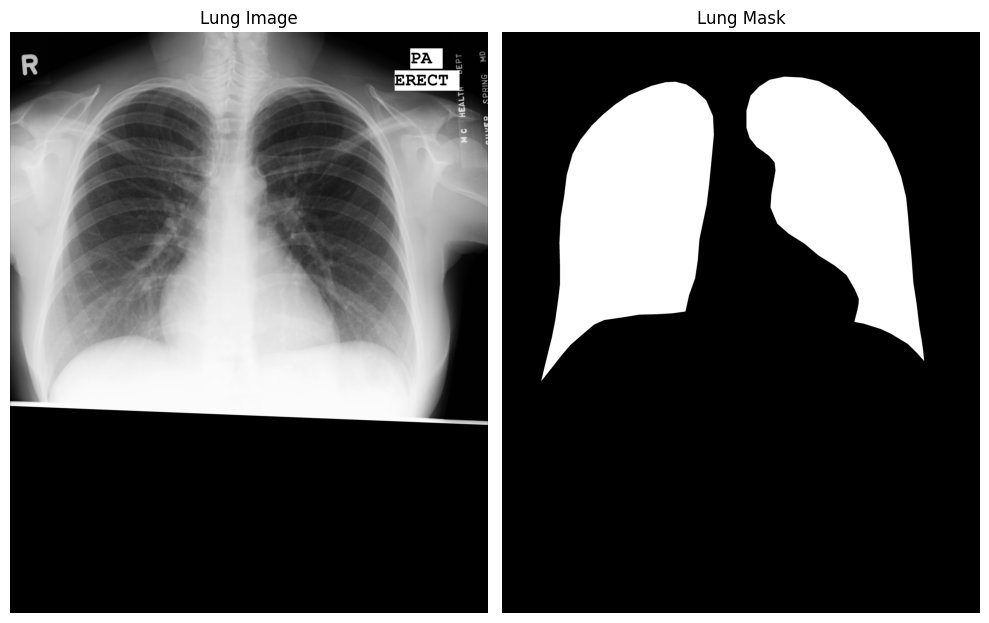

In [210]:
# Sample of a lung image and label.

# 0 >= i <= 703
i = 703 # Adjust to see different images.

plt.subplots(1,2, figsize = (10,10))

plt.subplot(1,2,1)
plt.title("Lung Image")
im = Image.open(lung_image_paths[i])
plt.imshow(im, cmap = "gray")
plt.axis(False);

plt.subplot(1,2,2)
plt.title("Lung Mask")
im = Image.open(lung_mask_paths[i])
plt.axis(False)
plt.imshow(im, cmap = "gray")

plt.tight_layout();

### Skin lesion Images

In [213]:
# Creating base dir for lung images
os.makedirs(SKIN_LESION_BASE_DIR, exist_ok = True)

# Downloading dataset.
!wget --no-check-certificate '{SKIN_LESION_IMAGES}' -O {os.path.join(SKIN_LESION_BASE_DIR, "dataset.zip")}

# Extracting downloaded dataset
with zipfile.ZipFile(os.path.join(SKIN_LESION_BASE_DIR, "dataset.zip"), 'r') as zip_ref:
    zip_ref.extractall(SKIN_LESION_BASE_DIR)
    
# Deleting zipped file
os.remove(os.path.join(SKIN_LESION_BASE_DIR, "dataset.zip"))

# Downloading binary masks.
!wget --no-check-certificate '{SKIN_LESION_BINARY_MASKS}' -O {os.path.join(SKIN_LESION_BASE_DIR, "bin_mask.zip")}

# Extracting binary masks
with zipfile.ZipFile(os.path.join(SKIN_LESION_BASE_DIR, "bin_mask.zip"), 'r') as zip_ref:
    zip_ref.extractall(SKIN_LESION_BASE_DIR)
    
# Deleting zipped file
os.remove(os.path.join(SKIN_LESION_BASE_DIR, "bin_mask.zip"))

# Moving csv file out to avoid mismatch issues later.
os.rename(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data", "ISIC-2017_Training_Data_metadata.csv"), os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data_metadata.csv"))

--2024-06-25 15:11:38--  https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.200.97, 3.5.27.192, 3.5.28.150, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.200.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6229496702 (5.8G) [application/zip]
Saving to: '/kaggle/working/skin_lesion/dataset.zip'

/kaggle/working/ski 100%[===================>]   5.80G  17.1MB/s    in 5m 46s  

2024-06-25 15:17:25 (17.2 MB/s) - '/kaggle/working/skin_lesion/dataset.zip' saved [6229496702/6229496702]



In [377]:
csv_ = pd.read_csv(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data_metadata.csv"))
csv_.head()

,image_id,age_approximate,sex
0,ISIC_0000000,55,female
1,ISIC_0000001,30,female
2,ISIC_0000002,60,female
3,ISIC_0000003,30,male
4,ISIC_0000004,80,male


In [378]:
# Sorting Train Image Paths
lesion_image_paths = []
lesion_mask_paths = []

for path, bin_path in zip(
    os.scandir(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data")),
    os.scandir(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Part1_GroundTruth"))
):
    
    # Adding all binary label paths to list.
    lesion_mask_paths.append(os.path.join(SKIN_LESION_BASE_DIR, bin_path))
    
    if path.name.endswith("jpg"): # Checking if the picture is jpg meaning image (superpixel masks)
        lesion_image_paths.append(os.path.join(SKIN_LESION_BASE_DIR, path)) # Adding all image paths to list
    
    elif path.name.endswith("png"): # Deleting "superpixel masks"
        os.remove(os.path.join(SKIN_LESION_BASE_DIR, path))
        
# # Sorting both lists so that images and labels match.
lesion_image_paths, lesion_mask_paths = sorted(lesion_image_paths), sorted(lesion_mask_paths)

print(f"Skin Lesion:\nThere are {len(lesion_image_paths)} training images, and {len(lesion_mask_paths)} masks.")

Skin Lesion:
There are 2000 training images, and 2000 masks.


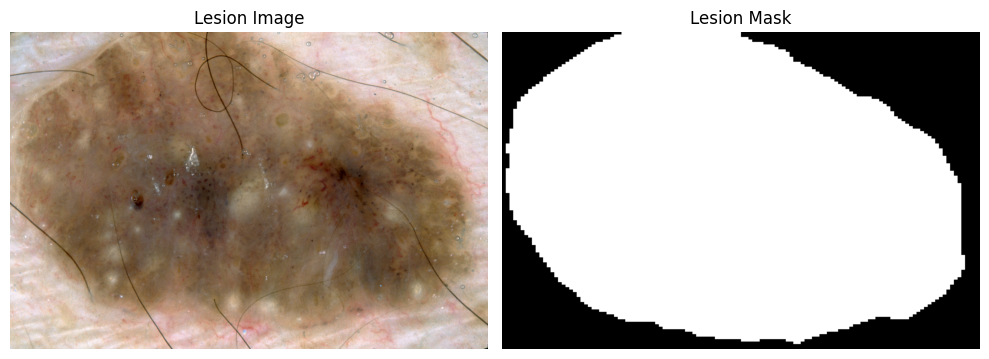

In [380]:
# Sample of a lesion image and label.

# 0 >= i <= 1999
i = 1999 # Adjust to see different images.

plt.subplots(1,2, figsize = (10,10))

plt.subplot(1,2,1)
plt.title("Lesion Image")
image = Image.open(lesion_image_paths[i])
plt.imshow(image, cmap = "gray")
plt.axis(False);

plt.subplot(1,2,2)
plt.title("Lesion Mask")
mask = Image.open(lesion_mask_paths[i])
plt.axis(False)
plt.imshow(mask, cmap = "gray")

plt.tight_layout();

# Data Pre-processing & Augmentation

In [577]:
# Defining Standardz.
IMAGE_SIZE = 512
BATCH_SIZE = 4
TEST_SIZE = 0.1 # Percentage of data to use for testing.
VAL_SIZE = 0.1 # Percentage of data to use for evaluation (During Training).
R_FULL = len(retina_image_paths) # Retina full data amount 
LU_FULL = len(lung_image_paths) # Lungs full data amount
LE_FULL = len(lesion_image_paths) # Lesion full data amount

# Calculating TEST_SIZE, and VAL_SIZE for each data set.
retina_v_per = int(len(retina_image_paths) * VAL_SIZE) # Validation size
lung_v_per = int(len(lung_image_paths) * VAL_SIZE) # Validation size
lesion_v_per = int(len(lesion_image_paths) * VAL_SIZE) # Validation size

retina_t_per = int(len(retina_image_paths) * TEST_SIZE) # Test size
lung_t_per = int(len(lung_image_paths) * TEST_SIZE) # Test size
lesioner = int(len(lesion_image_paths) * TEST_SIZE) # Test size

# Extracting Training, Test, and Validation data... Extracting first, and last n file paths.
retina_train_images, retina_train_masks = retina_image_paths[:R_FULL - (retina_v_per + retina_t_per)], retina_mask_paths[:R_FULL - (retina_v_per + retina_t_per)] # First "n" file paths
retina_val_images, retina_val_masks = retina_image_paths[- (retina_v_per + retina_t_per): - retina_t_per], retina_mask_paths[- (retina_v_per + retina_t_per): - retina_t_per] # Next "n" starting at first n + 1 and stopping before last.
retina_test_images, retina_test_masks = retina_image_paths[- retina_t_per:], retina_mask_paths[- retina_t_per:] # Last "n"

lung_train_images, lung_train_masks = lung_image_paths[:LU_FULL - (lung_v_per + lung_t_per)], lung_mask_paths[:LU_FULL - (lung_v_per + lung_t_per)] # First "n" file paths
lung_val_images, lung_val_masks = lung_image_paths[- (lung_v_per + lung_t_per): - lung_t_per], lung_mask_paths[- (lung_v_per + lung_t_per): - lung_t_per] # Next "n" starting at first n + 1 and stopping before last.
lung_test_images, lung_test_masks = lung_image_paths[- lung_t_per:], lung_mask_paths[- lung_t_per:] # Last "n"

lesion_train_images, lesion_train_masks = lesion_image_paths[:LE_FULL - (lesion_v_per + lesion_t_per)], lesion_mask_paths[:LE_FULL - (lesion_v_per + lesion_t_per)] # First "n" file paths
lesion_val_images, lesion_val_masks = lesion_image_paths[- (lesion_v_per + lesion_t_per): - lesion_t_per], lesion_mask_paths[- (lesion_v_per + lesion_t_per): - lesion_t_per] # Next "n" starting at first n + 1 and stopping before last.
lesion_test_images, lesion_test_masks = lesion_image_paths[- lesion_t_per:], lesion_mask_paths[- lesion_t_per:] # Last "n"

full_train_image, full_train_mask = sorted((retina_train_images + lung_train_images + lesion_train_images)), sorted((retina_train_masks + lung_train_masks + lesion_train_masks))
full_val_image, full_val_mask = sorted((retina_val_images + lung_val_images + lesion_val_images)), sorted((retina_val_masks + lung_val_masks + lesion_val_masks))
full_test_image, full_test_mask = sorted((retina_test_images + lung_test_images + lesion_test_images)), sorted((retina_test_masks + lung_test_masks + lesion_test_masks))

print("There are (Un-augmented)")
print(f"{len(full_train_image)} training images, and {len(full_train_mask)} training masks")
print(f"{len(full_val_image)} validation images, and {len(full_val_mask)} validation masks")
print(f"{len(full_test_image)} test images, and {len(full_test_mask)} test masks")
print(f"\nIn all the images above, there are {R_FULL} retina pairs, {LU_FULL} lung pairs, and {LE_FULL} lesion pairs.")
print("="*50)
print(f"||--------||Training\t||Validation\t||Test\t||")
print("-"*50)
print(f"|| Retina ||\t{len(retina_train_images)}\t||\t{len(retina_val_images)}\t||{len(retina_test_images)}\t||")
print(f"|| Lungs  ||\t{len(lung_train_images)}\t||\t{len(lung_val_images)}\t||{len(lung_val_images)}\t||")
print(f"|| Lesion ||\t{len(lesion_train_images)}\t||\t{len(lesion_val_images)}\t||{len(lesion_test_images)}\t||")
print("="*50)

There are (Un-augmented)
2321 training images, and 2321 training masks
290 validation images, and 290 validation masks
290 test images, and 290 test masks

In all the images above, there are 101 retina pairs, 800 lung pairs, and 2000 lesion pairs.
||--------||Training	||Validation	||Test	||
--------------------------------------------------
|| Retina ||	81	||	10	||10	||
|| Lungs  ||	640	||	80	||80	||
|| Lesion ||	1600	||	200	||200	||


## Defining Augmentation Pipeline